# Анализ развлекательного приложения Procrastinate Pro+

**Описание проекта**

Несмотря на огромные вложения в рекламу, последние несколько месяцев компания, разработавшая приложение Procrastinate Pro+, терпит убытки. Цель — разобраться в причинах и помочь компании выйти в плюс.


**Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:**
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

**Этапы исследования:**
1. Предобработка данных
2. Написание функций для расчёта и анализа LTV, ROI, удержания и конверсии
3. Составление профилей пользователей
4. Выяснение из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей
5. Исследование устройств, которыми пользуются клиенты и какие устройства предпочитают платящие пользователи
6. Изучение рекламных источников привлечения и определение каналов, из которых пришло больше всего платящих пользователей
7. Подсчет общей суммы расходов на маркетинг
8. Исследование как траты распределены по рекламным источникам
9. Подсчет сколько в среднем стоило привлечение одного пользователя из каждого источника
10. Анализ окупаемости рекламы
11. Выводы

### Загрузка данных и подготовка их к анализу

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import date, datetime, timedelta
import seaborn as sns
import datetime
import math

In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [4]:
#приведем названия столбцов к правильному формату
visits = visits.rename(columns = {'User Id':'user_id','Region':'region','Device':'device','Channel':'channel','Session Start':'session_start','Session End':'session_end'})

In [5]:
visits.head()

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [7]:
#приведем названия столбцов к правильному формату
orders = orders.rename(columns={'User Id':'user_id','Event Dt':'event_dt','Revenue':'revenue'})

In [8]:
orders.head()

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [9]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [10]:
#приведем названия столбцов к правильному формату
costs = costs.rename(columns={'Channel':'channel'})

In [11]:
costs.head()

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


**Проверим данные на наличие пропусков:**


In [12]:
visits.isna().sum()

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

In [13]:
orders.isna().sum()

user_id     0
event_dt    0
revenue     0
dtype: int64

In [14]:
costs.isna().sum()

dt         0
channel    0
costs      0
dtype: int64

**Преобразуем данные к нужному типу:**

In [15]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt'])

**Исследуем наличие дубликатов:**

In [16]:
visits.duplicated().sum()

0

In [17]:
visits['region'].unique()

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

In [18]:
visits['device'].unique()

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

In [19]:
visits['channel'].unique()

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

In [20]:
orders.duplicated().sum()

0

In [21]:
costs.duplicated().sum()

0

In [22]:
costs['channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

Дубликаты отсутствуют

**Исследуем аномалии в данных:**

In [23]:
orders['revenue'].describe()

count    40212.000000
mean         5.370608
std          3.454208
min          4.990000
25%          4.990000
50%          4.990000
75%          4.990000
max         49.990000
Name: revenue, dtype: float64

<AxesSubplot:>

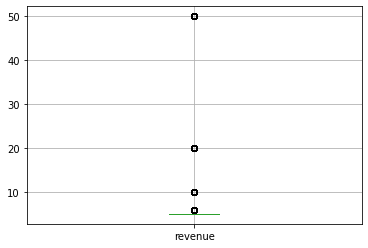

In [24]:
orders.boxplot('revenue')

In [25]:
costs['costs'].describe()

count    1800.000000
mean       58.609611
std       107.740223
min         0.800000
25%         6.495000
50%        12.285000
75%        33.600000
max       630.000000
Name: costs, dtype: float64

(500.0, 700.0)

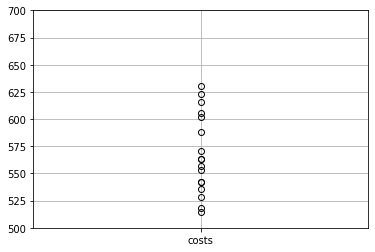

In [26]:
costs.boxplot('costs')
plt.ylim(500,700)

Видим, что присутствуют аномально большие значения, однако однозначно утверждать, что это ошибочные значения, сложно, так как действительно могли происходить настолько дорогие покупки и затраты на рекламные кампании, поэтому удалять их не будем

### Функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

Функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [27]:
# функция для создания пользовательских профилей
def get_profiles(sessions, orders, ad_costs):
    profiles = (
        sessions.sort_values(by=['user_id','session_start'])
        .groupby('user_id')
        .agg({'session_start':'first','channel':'first','region':'first','device':'first'})
        .rename(columns={'session_start':'first_ts'})
        .reset_index()
    )
    
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['dt'] = pd.to_datetime(profiles['dt'], format="%Y-%m-%d")
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    
    new_users = (
        profiles.groupby(['dt','channel'])
        .agg({'user_id':'nunique'})
        .rename(columns={'user_id':'unique_users'})
        .reset_index()
    )
   
    ad_costs = ad_costs.merge(new_users, on=['dt','channel'], how='left')
    
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    return profiles

In [28]:
# функция для расчёта Retention Rate
def get_retention(profiles, sessions, observation_date, horizon_days, dimensions=[], ignore_horizon=False,):
    
    dimensions = ['payer'] + dimensions
    
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    
    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on='user_id', how='left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days
    
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return result_raw, result_grouped, result_in_time

In [29]:
# функция для расчёта Conversion Rate
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    if 'cohort' in dimensions: 
        dimensions = []

    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return result_raw, result_grouped, result_in_time

In [30]:
# функция для расчёта LTV
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    
    def group_by_dimensions(df, dims, horizon_days):
       
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        
        result = result.fillna(0).cumsum(axis=1)
       
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        
        result = result.div(result['cohort_size'], axis=0)
        
        result = result[['cohort_size'] + list(range(horizon_days))]
       
        result['cohort_size'] = cohort_sizes

        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        roi = result.div(cac['cac'], axis=0)

        roi = roi[~roi['cohort_size'].isin([np.inf])]

        roi['cohort_size'] = cohort_sizes

        roi['cac'] = cac['cac']

        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    if 'cohort' in dimensions:
        dimensions = []

    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  
        result_grouped,  
        result_in_time,  
        roi_grouped,  
        roi_in_time,
    )

In [31]:
#функция для сглаживания данных:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [32]:
#функция для построения графика Retention Rate:
def plot_retention(retention, retention_history, horizon, window=7):

    plt.figure(figsize=(15, 10))

    retention = retention.drop(columns=['cohort_size', 0])
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    ax3 = plt.subplot(2, 2, 3)
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [33]:
# функция для построения графика конверсии
def plot_conversion(conversion, conversion_history, horizon, window=7):

    plt.figure(figsize=(15, 5))

    conversion = conversion.drop(columns=['cohort_size'])

    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [34]:
# функция для визуализации LTV и ROI
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

   
    cac_history = roi_history[['cac']]

    
    roi = roi.drop(columns=['cohort_size', 'cac'])
    
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

   
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')


    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

   
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

In [35]:
#составим профили пользователей
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,region,device,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,United States,Mac,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,United States,iPhone,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,France,iPhone,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,Germany,PC,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,United States,iPhone,2019-10-02,2019-10-01,False,0.230769


In [36]:
min_dt = profiles['dt'].min()
max_dt = profiles['dt'].max()
print('Минимальная дата привлечения пользователей:', min_dt)
print('Максимальная дата привлечения пользователей:', max_dt)

Минимальная дата привлечения пользователей: 2019-05-01 00:00:00
Максимальная дата привлечения пользователей: 2019-10-27 00:00:00


**Данные соответствуют условиям: минимальная дата привлечения пользователей - 1 мая 2019, максимальная - 27 октября 2019**

In [37]:
#Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей
region_stat = profiles[['user_id','region']].copy()
region_stat = region_stat.groupby('region')['user_id'].count()
region_stat = region_stat.to_frame().rename(columns={'user_id':'users_count'})
region_stat['share'] = ((region_stat['users_count']/profiles['user_id'].count())*100)
region_stat.sort_values(by='share', ascending=False).style.format({'share':'{:.2f}%'})


,users_count,share
region,,
United States,100002,66.66%
UK,17575,11.72%
France,17450,11.63%
Germany,14981,9.99%


**На основе полученных результатов можно сделать вывод, что наибольшее количество пользователей - из США (66,7%). Доли Англии и Франции примерно равны (~12%). Меньше всего пользователей из Германии (9,99%)**


In [38]:
region_stat_pay = profiles[['user_id','region','payer']].copy().query('payer == True').groupby('region')['user_id'].count()
region_stat_pay = region_stat_pay.to_frame().rename(columns={'user_id':'paying_users_count'})
region_stat_pay['paying_share'] = (region_stat_pay['paying_users_count']/profiles.query('payer == True')['region'].count())*100
region_stat_pay = region_stat_pay.sort_values(by='paying_share', ascending=False)
region_stat_pay.style.format({'paying_share':'{:.2f}%'})

,paying_users_count,paying_share
region,,
United States,6902,77.72%
UK,700,7.88%
France,663,7.47%
Germany,616,6.94%


**Наибольшая доля платящих пользователей - в США (77,72%). Далее идут Англия и Франция с долями около 12% и последняя в списке - Германия с долей ~7% платящих пользователей**

In [39]:
#Доля платящих пользователей отдельно по странам
region_share = region_stat.merge(region_stat_pay, on='region', how='left')
region_share = region_share.drop(columns='paying_share')
region_share['payer_share'] = (region_share['paying_users_count']/region_share['users_count'])*100
region_share.sort_values(by='users_count', ascending=False).style.format({'payer_share':'{:.2f}%','share':'{:.2f}%'})

,users_count,share,paying_users_count,payer_share
region,,,,
United States,100002,66.66%,6902,6.90%
UK,17575,11.72%,700,3.98%
France,17450,11.63%,663,3.80%
Germany,14981,9.99%,616,4.11%


**Лидирует США: доля платящих пользователей составляет 6,9%. Доля платящих в Германии составила 4,11%, а наименьшие доли у Франции и Англии - 3,8% и 3,98% соответственно**

In [40]:
#Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи
device_stat = profiles[['user_id','device','payer']]
device_stat = device_stat.groupby('device')['user_id'].count().to_frame().rename(columns={'user_id':'users_count'})
device_stat['share'] = (device_stat['users_count']/profiles['user_id'].count())*100
device_stat.sort_values(by='share', ascending=False).style.format({'share':'{:.2f}%'})

,users_count,share
device,,
iPhone,54479,36.32%
Android,35032,23.35%
PC,30455,20.30%
Mac,30042,20.03%


**В основном пользователи используют мобильные устройства: iPhone(36,2%) и Android(23,35%). PC и Mac менее популярны: их используют ~20% пользователей**

In [41]:
device_stat_pay = profiles[['user_id','device','payer']]
device_stat_pay = device_stat_pay.query('payer == True').groupby('device')['user_id'].count().to_frame().rename(columns={'user_id':'paying_users_count'})
device_stat_pay['paying_share'] = (device_stat_pay['paying_users_count']/profiles.query('payer == True')['user_id'].count())*100
device_stat_pay.sort_values(by='paying_share', ascending=False).style.format({'paying_share':'{:.2f}%'})

,paying_users_count,paying_share
device,,
iPhone,3382,38.08%
Android,2050,23.08%
Mac,1912,21.53%
PC,1537,17.31%


**Статистика платящих пользователей примерно та же, что и статистика всех пользователей в целом: лидируют мобильные устройства**

In [42]:
#Доля платящих пользователей отдельно по устройствам
device_share = device_stat.merge(device_stat_pay, on='device', how='left')
device_share = device_share.drop(columns='paying_share')
device_share['payer_share'] = (device_share['paying_users_count']/device_share['users_count'])*100
device_share.sort_values(by='payer_share', ascending=False).style.format({'payer_share':'{:.2f}%','share':'{:.2f}%'})

,users_count,share,paying_users_count,payer_share
device,,,,
Mac,30042,20.03%,1912,6.36%
iPhone,54479,36.32%,3382,6.21%
Android,35032,23.35%,2050,5.85%
PC,30455,20.30%,1537,5.05%


**Результаты показали, что наибольшая доля платящих - среди пользователей Mac и iPhone (6,36% и 6,21% соответственно). Среди пользователей Android она составила 5,85%, PC - 5,05%**

In [43]:
#Изучим рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей
channels = profiles[['user_id','channel']]
channels = channels.groupby('channel')['user_id'].count().to_frame().rename(columns={'user_id':'users_count'})
channels['share'] = (channels['users_count']/profiles['user_id'].count())*100
channels.sort_values(by='users_count', ascending=False).style.format({'share':'{:.2f}%'})

,users_count,share
channel,,
organic,56439,37.62%
FaceBoom,29144,19.43%
TipTop,19561,13.04%
OppleCreativeMedia,8605,5.74%
LeapBob,8553,5.70%
WahooNetBanner,8553,5.70%
RocketSuperAds,4448,2.97%
MediaTornado,4364,2.91%
YRabbit,4312,2.87%


**Наибольшая доля пользователей приходится на органический канал (37,62%). Далее по списку лидируют FaceBoom (19,43%) и Tip Top (13,04%). Меньше всего пользователей привлекает lambdaMediaAds(1,43%)**

In [44]:
channel_payer = profiles[['user_id','channel','payer']]
channel_payer = channel_payer.query('payer == True').groupby('channel')['user_id'].count().to_frame().rename(columns={'user_id':'payer_count'})
channel_payer['payer_share'] = (channel_payer['payer_count']/profiles.query('payer==True')['user_id'].count())*100
channel_payer.sort_values(by='payer_count', ascending=False).style.format({'payer_share':'{:.2f}%'})

,payer_count,payer_share
channel,,
FaceBoom,3557,40.05%
TipTop,1878,21.15%
organic,1160,13.06%
WahooNetBanner,453,5.10%
AdNonSense,440,4.95%
RocketSuperAds,352,3.96%
LeapBob,262,2.95%
OppleCreativeMedia,233,2.62%
lambdaMediaAds,225,2.53%


**Среди платящих пользователей ситуация иная: наибольший трафик приходится на FaceBoom(40,05%). На втором месте расположился Tip Top с долей 21,15%, а на третьем - органический трафик (13,06%). Меньше всего платящих пользователей приходит из MediaTornado	(1.76%)**

In [45]:
channel_share = channels.merge(channel_payer, on='channel', how='left')
channel_share = channel_share.drop(columns='payer_share')
channel_share['payer_share'] = (channel_share['payer_count']/channel_share['users_count'])*100
channel_share.sort_values(by='payer_share', ascending=False).style.format({'share':'{:.2f}%','payer_share':'{:.2f}%'})

,users_count,share,payer_count,payer_share
channel,,,,
FaceBoom,29144,19.43%,3557,12.20%
AdNonSense,3880,2.59%,440,11.34%
lambdaMediaAds,2149,1.43%,225,10.47%
TipTop,19561,13.04%,1878,9.60%
RocketSuperAds,4448,2.97%,352,7.91%
WahooNetBanner,8553,5.70%,453,5.30%
YRabbit,4312,2.87%,165,3.83%
MediaTornado,4364,2.91%,156,3.57%
LeapBob,8553,5.70%,262,3.06%


**Топ-3 канала-лидера по долям платящих пользователей: FaceBoom(12,20%), AdNonSense	(11.34%), lambdaMediaAds (10.47%). Наименьшая доля платящих пользователей - из органического трафика (2,06%)**

**Вывод:** В целом в данном разделе был проведен хороший анализ данных - мы посмотрели на базовые значения конверсии пользователей в покупатели по регионам, устройствам и каналу привлечения, определили основной рынок. Получается, что больше всего приходит пользователей из США и они лучше других конвертируется. При этом большая часть пользователей заходит с мобильных устройств, это тоже стоит отметить. Также, мы можем сказать, что наибольшую конверсию имеют пользователи, которые пользуются Mac, а затем следуют пользователи iPhone, т.е. мы можем сказать, что в целом пользователи Apple имеют лучшую конверсию в покупателей. Возможно, тут есть плюсы ApplePay.

### Маркетинг


In [46]:
#Посчитааем общую сумму расходов на маркетинг
print('Общая сумма расходов на маркетинг:', costs['costs'].sum().round(1))

Общая сумма расходов на маркетинг: 105497.3


In [47]:
#Выясним, сколько денег было потрачено на каждый источник
channels_costs = costs[['channel','costs']].copy()
channels_costs = channels_costs.groupby('channel')['costs'].sum().to_frame()
channels_costs.sort_values(by='costs', ascending=False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


Text(0, 0.5, 'Затраты')

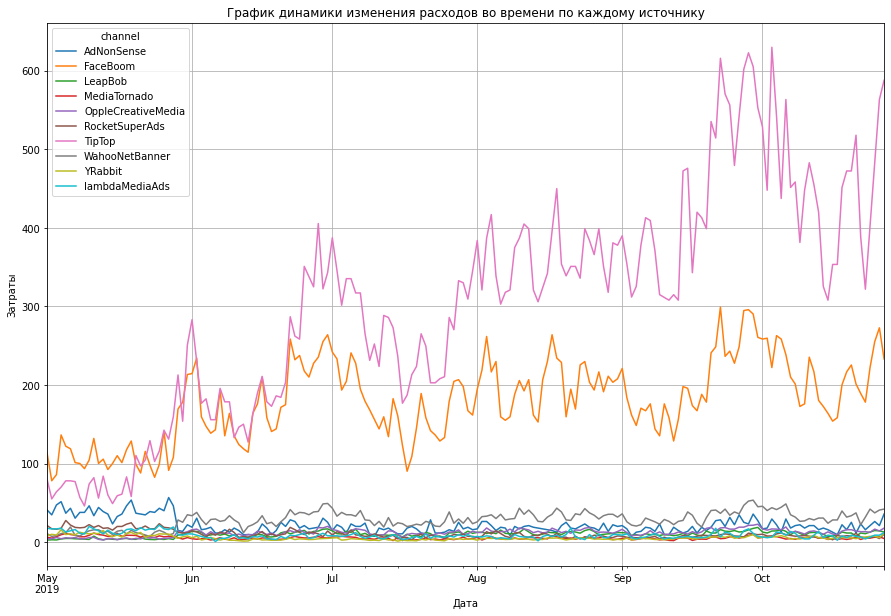

In [48]:
din_costs = costs.pivot_table(index='dt', columns='channel', values='costs', aggfunc='sum')
din_costs.plot(figsize=(15,10), grid=True)
plt.title('График динамики изменения расходов во времени по каждому источнику')
plt.xlabel('Дата')
plt.ylabel('Затраты')

Text(0, 0.5, 'Затраты')

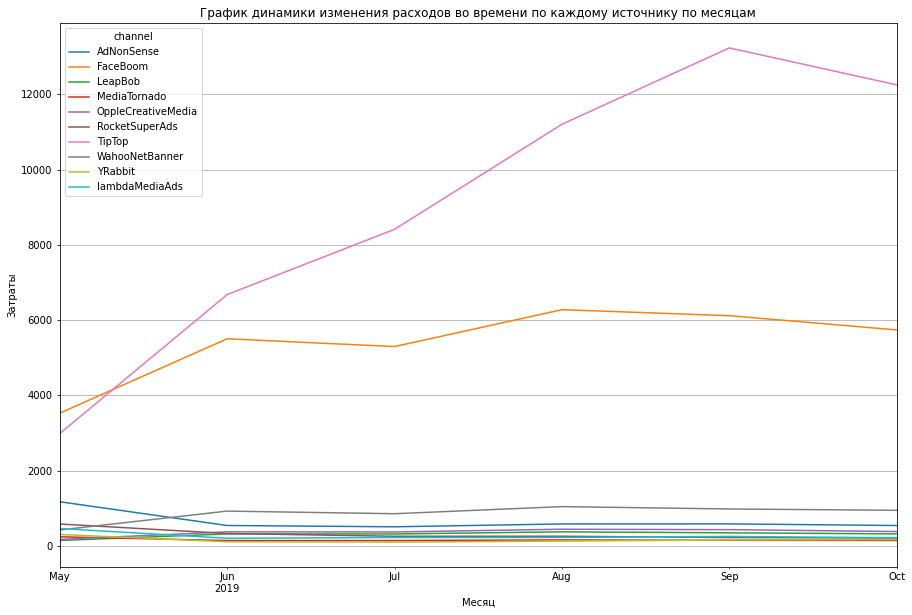

In [49]:
din_costs = costs.pivot_table(index=costs['dt'].astype('datetime64[M]'), columns='channel', values='costs', aggfunc='sum')
din_costs.plot(figsize=(15,10), grid=True)
plt.title('График динамики изменения расходов во времени по каждому источнику по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Затраты')

Text(0, 0.5, 'Затраты')

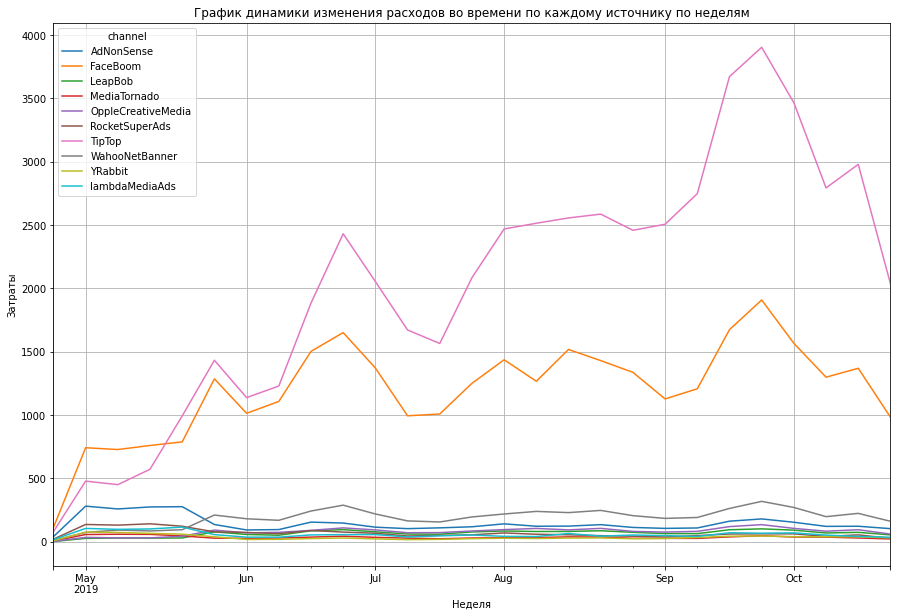

In [50]:
din_costs = costs.pivot_table(index=costs['dt'].astype('datetime64[W]'), columns='channel', values='costs', aggfunc='sum')
din_costs.plot(figsize=(15,10), grid=True)
plt.title('График динамики изменения расходов во времени по каждому источнику по неделям')
plt.xlabel('Неделя')
plt.ylabel('Затраты')

**Наибольшая сумма была вложена в покупку рекламы у канала Tip Top. Как мы видим на графике, расходы на рекламу у данного канала, постепенно увеличиваются. Следующим по объему затрат идет FaceBoom, однако расходы на данный канал стабильны: не увеличиваются, и не уменьшаются со временем. Остальные каналы обходятся гораздо дешевле, расходы на них не превышают даже отметки 100**

In [51]:
#Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC)
cac = channels.merge(channels_costs, on='channel', how='left').drop(columns='share')
cac['cac'] = cac['costs']/cac['users_count']
cac = cac.fillna(0)
cac.sort_values(by='cac', ascending=False)


,users_count,costs,cac
channel,,,
TipTop,19561,54751.30,2.799003
FaceBoom,29144,32445.60,1.113286
AdNonSense,3880,3911.25,1.008054
lambdaMediaAds,2149,1557.60,0.724802
WahooNetBanner,8553,5151.00,0.602245
RocketSuperAds,4448,1833.00,0.412095
OppleCreativeMedia,8605,2151.25,0.250000
YRabbit,4312,944.22,0.218975
MediaTornado,4364,954.48,0.218717


In [52]:
#посчитаем средний САС по проекту
cac_mean = cac.query('channel != "organic"')
print('средний САС по проекту:', cac_mean['cac'].mean().round(3))

средний САС по проекту: 0.756


**Наиболее дорогостоящим каналом привлечения пользователей является TipTop, однако количество и доля платящих пользователей, приходящих с этого источника, не так высоки. Это можно объяснить молодой аудиторией TipTop'a и, соответственно, не очень высокой их платежеспособностью.**

**Вывод:**
В результате анализа маркетинговой кампании был изучен объем расходов на каждый канал и проанализирована их динамика. Выяснилось, что наибольшая сумма была вложена в покупку рекламы у канала Tip Top, расходы на рекламу у данного канала постепенно увеличиваются. Следующим по объему затрат идет FaceBoom, однако расходы на данный канал стабильны. Остальные каналы обходятся гораздо дешевле. Наиболее дорого обходится пользователи, привлеченные через канал Tip Top (2,799). Примерно одинаково стоят пользователи из FaceBoom и AdNonSense (1,11 и 1 соответственно). Через остальные каналы пользователи стоят 0,72 и меньше. Средний САС по всему проекту составил 0.756

### Оценка окупаемости рекламы

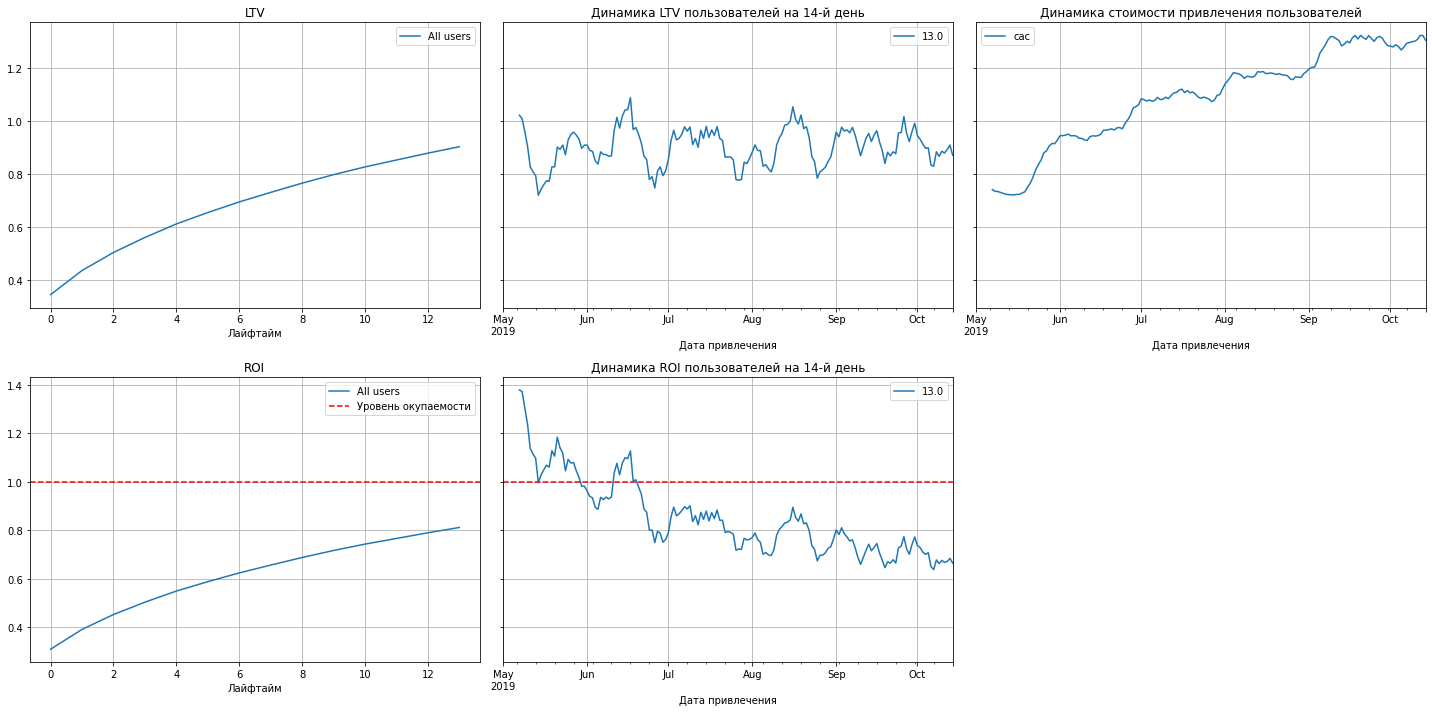

In [53]:
profiles = profiles.query('channel != "organic"')
observation_date = max_dt
horizon_days = 14
ltv_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(profiles, orders, observation_date, horizon_days)
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, horizon_days)

**На основе графиков можно сделать следующие выводы:**
- Показатель LTV стабилен
- CAC имеет тенденцию к увеличению, что говорит о постоянном увеличении затрат на маркетинг
- Реклама в течение 2 недель не окупается 
- ROI пользователей динамично снижается и после июня стал ниже уровня окупаемости

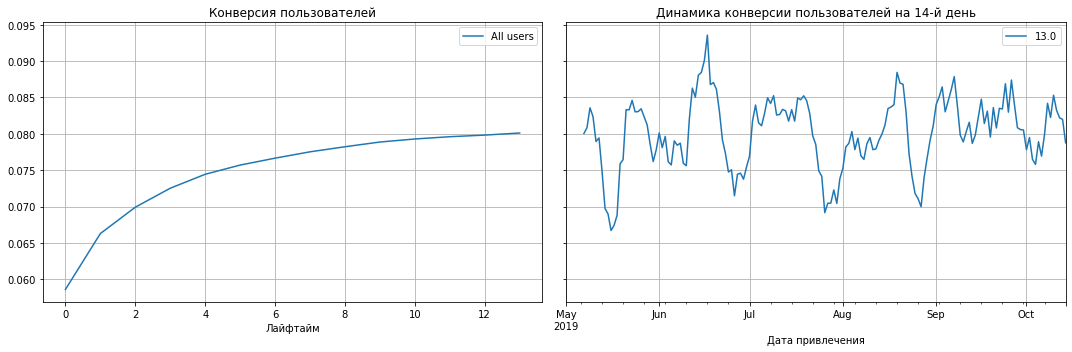

In [54]:
conversion_raw, conversion_grouped, conversion_in_time = get_conversion(profiles, orders, observation_date, horizon_days)
plot_conversion(conversion_grouped, conversion_in_time, horizon_days, window=7)

**По графикам видно, что конверсия пользователей в целом стабильна и не имеет динамики ни к увеличению, ни к снижению**

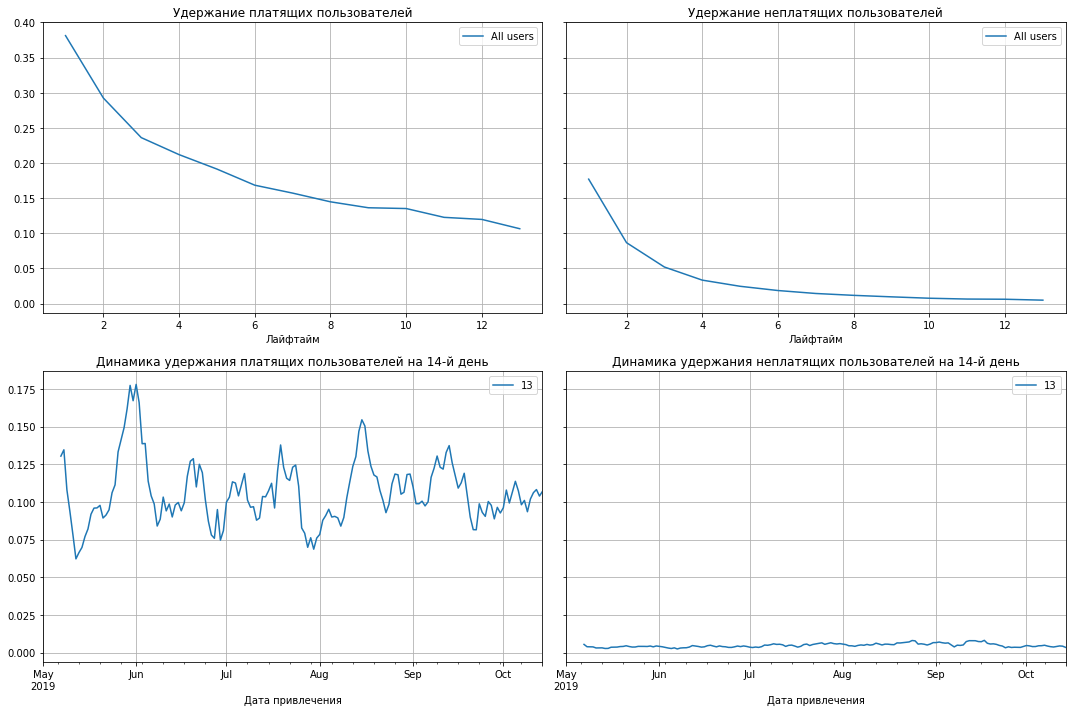

In [55]:
retention_raw, retention_grouped, retention_in_time = get_retention(profiles, visits, observation_date, horizon_days)
plot_retention(retention_grouped, retention_in_time, horizon_days, window=7)

**Видим, что удержание платящих пользователей гораздо выше, нежели неплатящих. На 14 день не платящие пользователи практически не остаются в приложении**


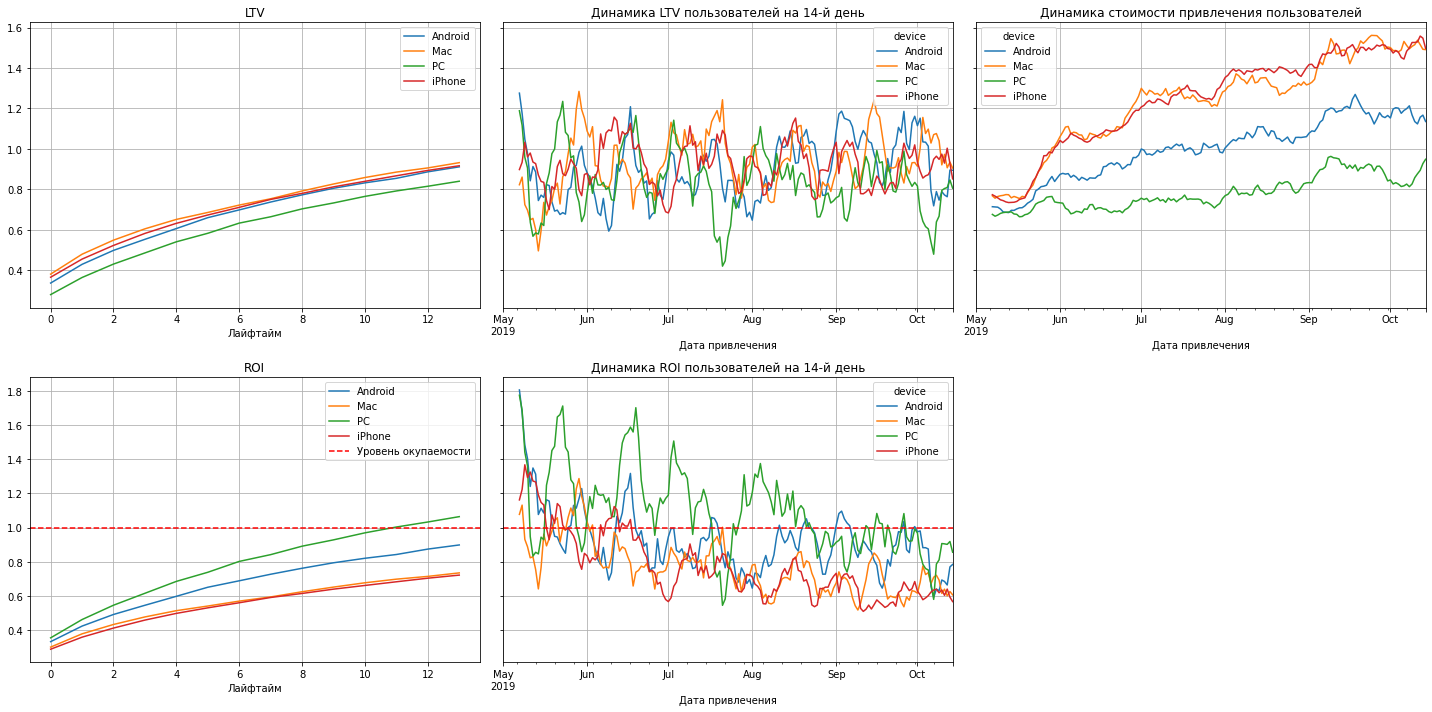

In [56]:
#окупаемость рекламы с разбивкой по устройствам
dimensions=['device']
ltv_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(profiles, orders, observation_date, horizon_days,dimensions=dimensions)
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, horizon_days)

**Выводы по графикам:**
- LTV у всех устройств стабилен, наименьший - у пользователей PC
- Стоимость привличения пользователей растет у всех устройств, однако наиболее динамично у iPhone и Mac (у них же САС наиболее высокий). Наиболее дешево привлеченные - пользователи PC
- С окупаемостью проблемы по всем устройствам кроме PC. Это значит, что у нас, по крайней мере, нет технических проблем, влияющих на монетизацию
- ROI на 14 день стремительно падает, к сентябрю он ниже окупаемости практически у всех устройств. Самый высокий ROI - у пользователей PC 


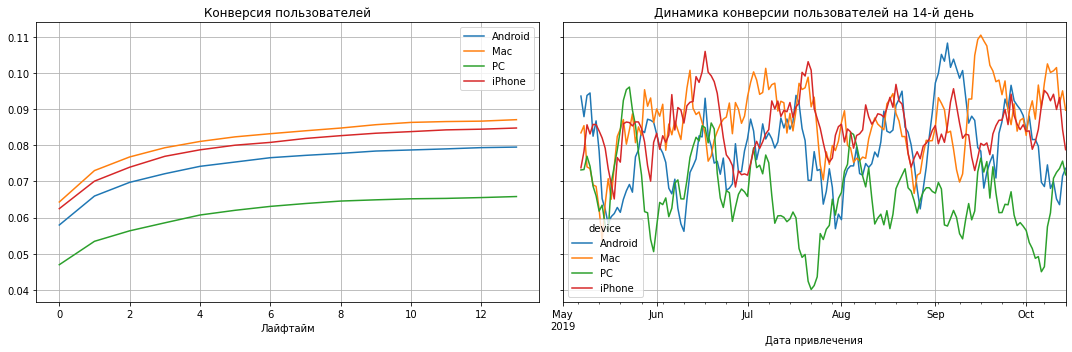

In [57]:
dimensions=['device']
conversion_raw, conversion_grouped, conversion_in_time = get_conversion(profiles, orders, observation_date, horizon_days, dimensions=dimensions)
plot_conversion(conversion_grouped, conversion_in_time, horizon_days, window=7)

**Наиболее высокую конверсию имеют пользователи Mac и iPhone, наименьшую - PC**

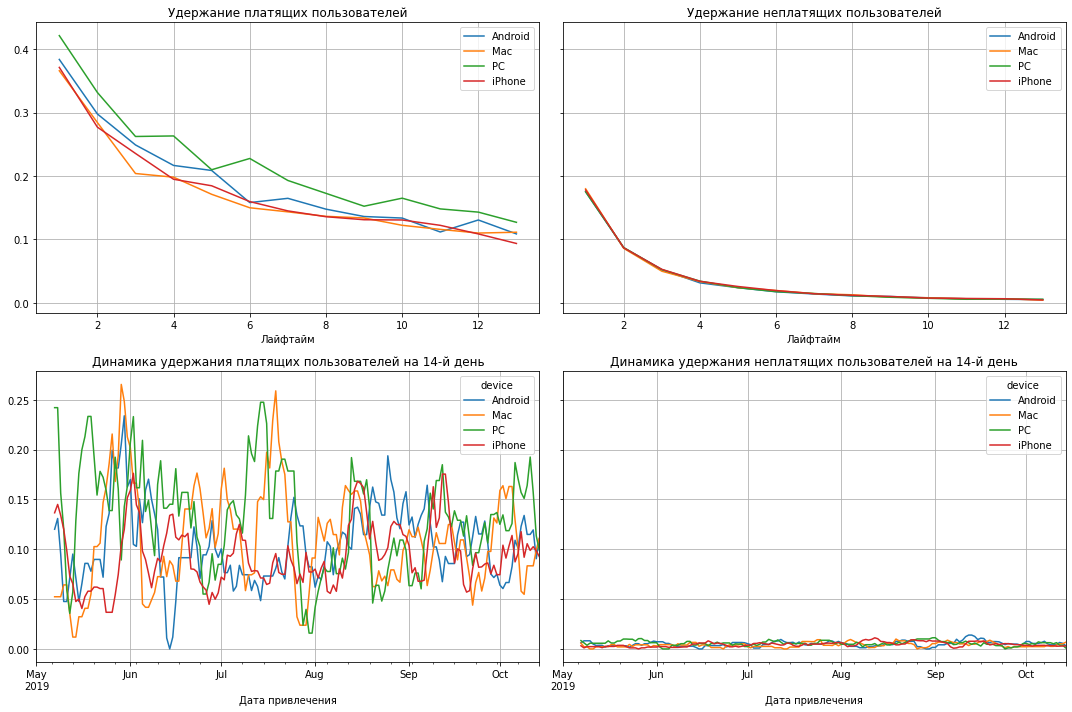

In [58]:
dimensions=['device']
retention_raw, retention_grouped, retention_in_time = get_retention(profiles, visits, observation_date, horizon_days, dimensions=dimensions)
plot_retention(retention_grouped, retention_in_time, horizon_days, window=7)

**Ожидаемо, что неплатящие пользователи всех устройств удерживаются одинаково плохо. Среди платящих пользователей лучше всего удерживаются PC, хуже - Mac и iPhone**

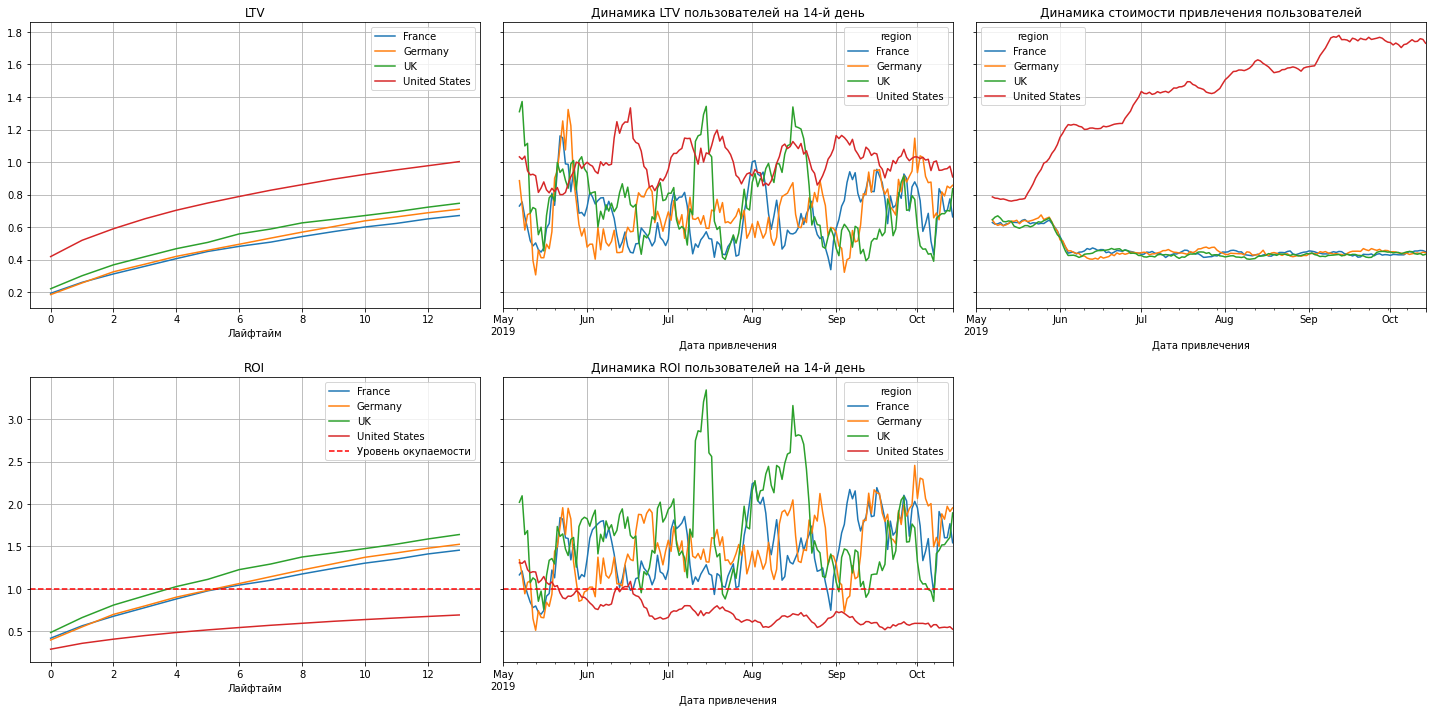

In [59]:
#окупаемость рекламы с разбивкой по странам
dimensions=['region']
ltv_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(profiles, orders, observation_date, horizon_days,dimensions=dimensions)
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, horizon_days)

**Выводы по графикам:**
- LTV стабилен, наиболее высокий - у пользователей из США
- Самая высокая стоимость привлечения пользователей из США, к тому же она постоянно увеличивается, стоимость пользователей из других стран стабильно дешевая
- Пользователи из всех стран окупаются, исключая США. К тому же, окупаемость стабильно снижается и в июле стала ниже порога

Нужно разбираться детальнее с рекламой в США, тем более, что это наш основной рынок. 

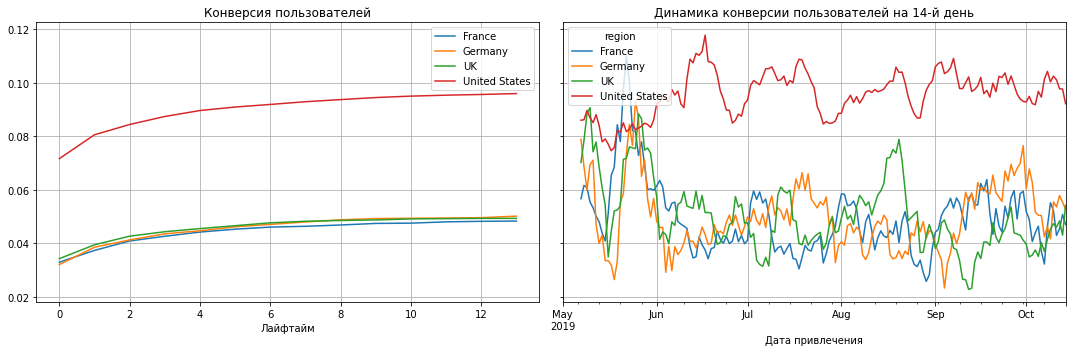

In [60]:
dimensions=['region']
conversion_raw, conversion_grouped, conversion_in_time = get_conversion(profiles, orders, observation_date, horizon_days, dimensions=dimensions)
plot_conversion(conversion_grouped, conversion_in_time, horizon_days, window=7)

**Явный лидер по конвертируемости пользователей - США. Остальные страны имеют примерно одинаковую и небольшую конверсию** 

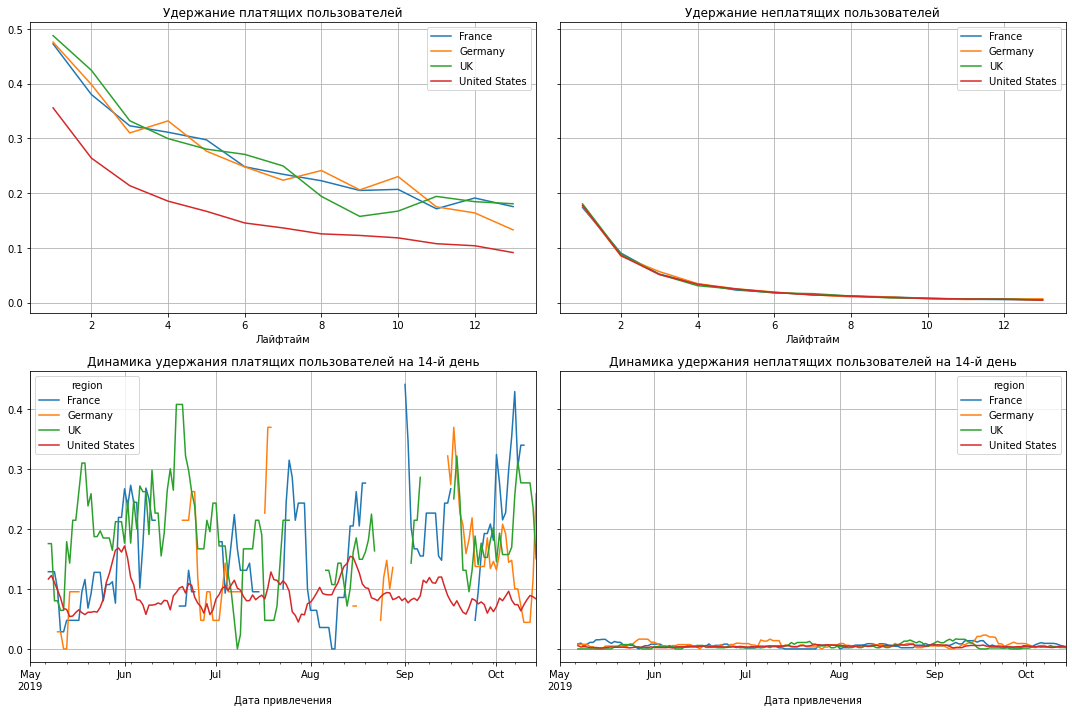

In [61]:
dimensions=['region']
retention_raw, retention_grouped, retention_in_time = get_retention(profiles, visits, observation_date, horizon_days, dimensions=dimensions)
plot_retention(retention_grouped, retention_in_time, horizon_days, window=7)

**А вот в удержании США проигрывает остальным странам**

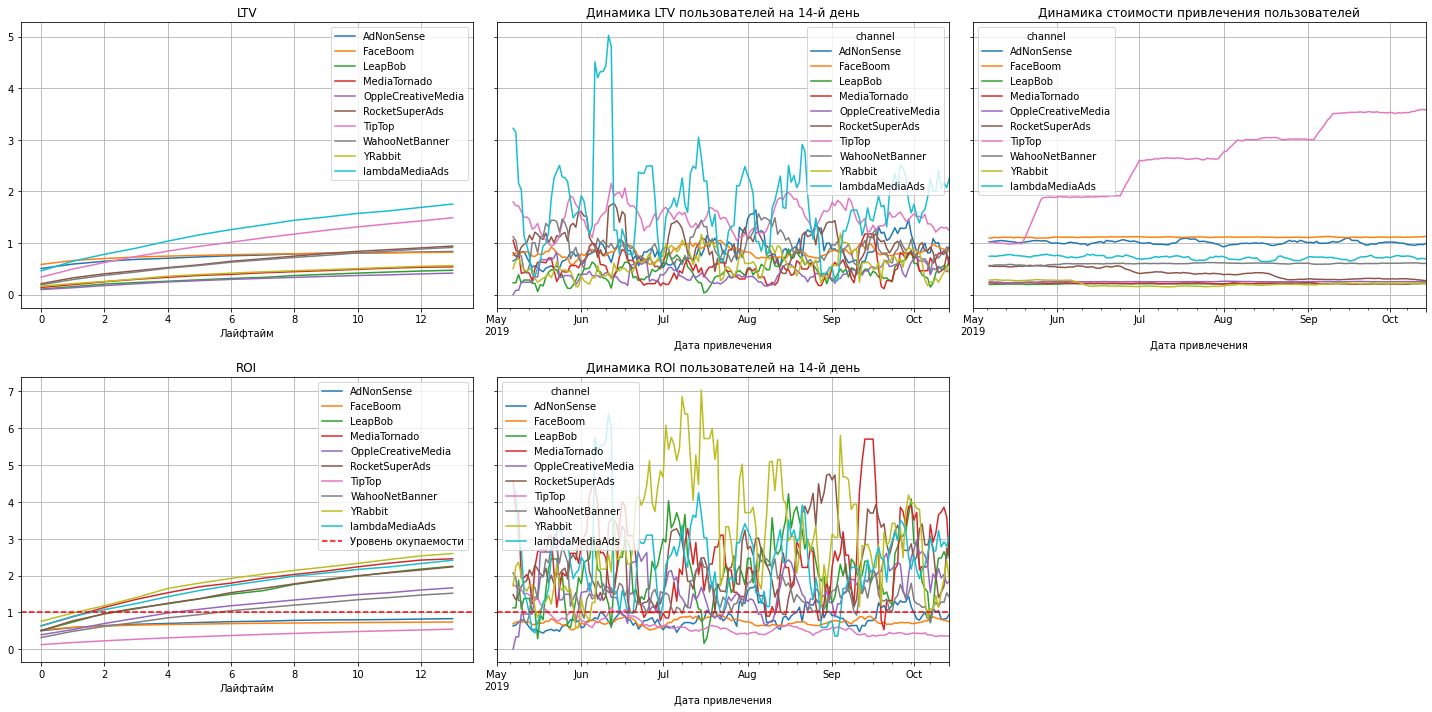

In [62]:
#окупаемость рекламы с разбивкой по рекламным каналам
dimensions=['channel']
ltv_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(profiles, orders, observation_date, horizon_days,dimensions=dimensions)
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, horizon_days)

**Выводы по графикам:**
- Стоимость привлечения пользователей из TipTop самая большая и к тому же она постоянно растет
- Не окупаются пользователи из TipTop, FaceBoom, LeapBob

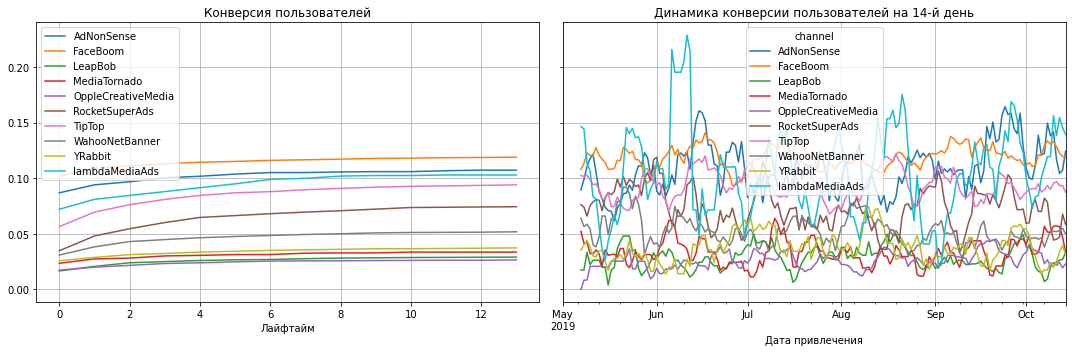

In [63]:
dimensions=['channel']
conversion_raw, conversion_grouped, conversion_in_time = get_conversion(profiles, orders, observation_date, horizon_days, dimensions=dimensions)
plot_conversion(conversion_grouped, conversion_in_time, horizon_days, window=7)

**Хуже всего конвертируются пользователи wahoonetbanner, leapboom, mediatornado, yrabbit. Лучше всего - FaceBoom, AdNonSense**

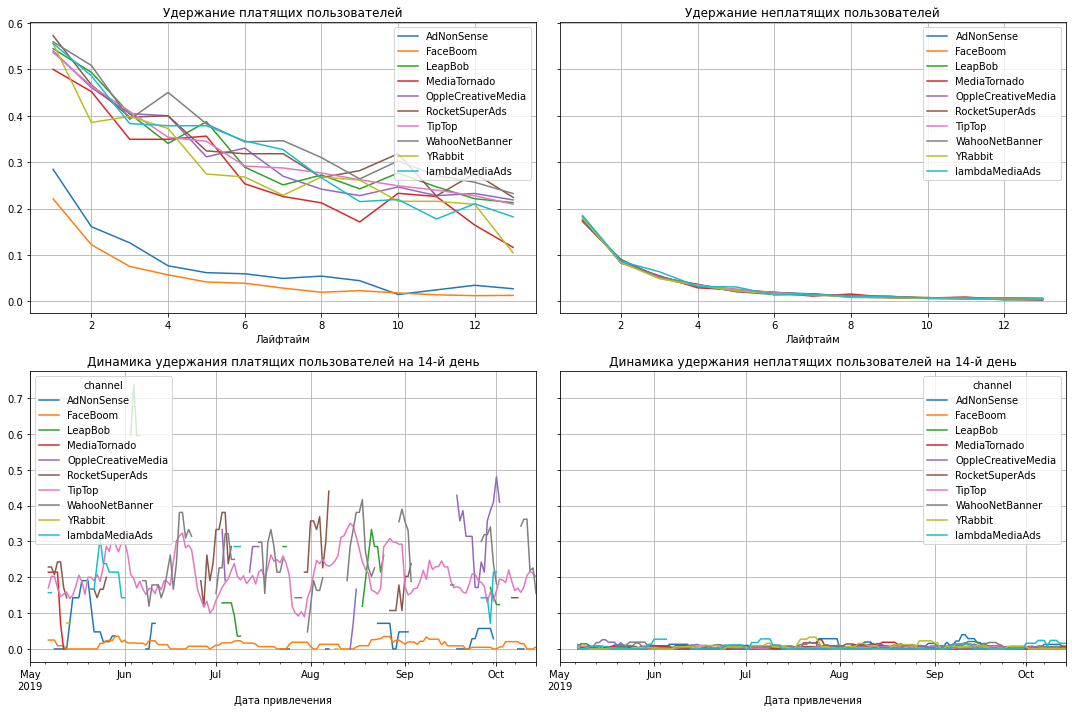

In [64]:
dimensions=['channel']
retention_raw, retention_grouped, retention_in_time = get_retention(profiles, visits, observation_date, horizon_days, dimensions=dimensions)
plot_retention(retention_grouped, retention_in_time, horizon_days, window=7)

**Вывод:**
По итогам оценки окупаемости выяснилось, что реклама в течение 14 дней не окупается , ROI пользователей динамично снижается и после июня стал ниже уровня окупаемости. CAC не стабилен и имеет тенденцию к увеличению. Стоимость привличения пользователей растет у всех устройств, однако наиболее динамично у iPhone и Mac (у них же САС наиболее высокий). Наиболее дешево привлеченные - пользователи PC. Пользователи PC окупаются на 11 день, а Android, iPhone и Mac не окупаются вовсе. ROI на 14 день стремительно падает, к сентябрю он ниже окупаемости практически у всех устройств. Самый высокий ROI - у пользователей PC. Наиболее высокую конверсию имеют пользователи Mac и iPhone, наименьшую - PC, однако среди платящих пользователей лучше всего удерживаются PC, хуже - Mac и iPhone. Самая высокая стоимость привлечения пользователей из США, к тому же она постоянно увеличивается, стоимость пользователей из других стран стабильно дешевая. Пользователи из всех стран окупаются, исключая США. К тому же, окупаемость пользователей из США стабильно снижается и в июле стала ниже порога. Явный лидер по конвертируемости пользователей - США, а вот в удержании США проигрывает остальным странам. Стоимость привлечения пользователей из TipTop самая большая и к тому же она постоянно растет. Не окупаются пользователи из TipTop, FaceBoom, LeapBob. Хуже всего конвертируются пользователи wahoonetbanner, leapboom, mediatornado, yrabbit. Лучше всего - FaceBoom, AdNonSense. Самый низкий показатель удержания среди платящих пользователей у FaceBoom и AdNonSense

**Самый низкий показатель удержания среди платящих пользователей у FaceBoom и AdNonSense**

1. Говоря об окупаемости в целом - порог окупаемости не достигается за 14 дней привлечения, что не соответствует бизнес-плану
2. Негативное влияние на окупаемость рекламы оказывают: пользователи Mac и iPhone, пользователи из США, а также пользователи, привлеченные из TipTop, FaceBoom, LeapBob
3. Проблемы окупаемости могут быть вызваны неправильной аллокацией средств среди каналов привлечения, наибольшие вложения были в источники, которые привлекают либо мало пользователей, либо пользователей "плохого качества"

### Выводы

**Итак, в результате анализа профилей пользователей было выявлено, что:**
- наибольшее количество пользователей - из США (66,7%). Доли Англии и Франции примерно равны (~12%). Меньше всего пользователей из Германии (9,99%)
- наибольшая доля платящих пользователей - в США (77,72%). Далее идут Англия и Франция с долями около 12% и последняя в списке - Германия с долей ~7% платящих пользователей
- по доляе платящих пользователей лидирует США (составляет 6,9%). Доля платящих в Германии составила 4,11%, а наименьшие доли у Франции и Англии - 3,8% и 3,98% соответственно
- в основном пользователи используют мобильные устройства: iPhone(36,2%) и Android(23,35%). PC и Mac менее популярны: их используют ~20% пользователей
- статистика платящих пользователей примерно та же, что и статистика всех пользователей в целом: лидируют мобильные устройства
- наибольшая доля платящих - среди пользователей Mac и iPhone (6,36% и 6,21% соответственно). Среди пользователей Android она составила 5,85%, PC - 5,05%
- Наибольшая доля пользователей приходится на органический канал (37,62%). Далее по списку лидируют FaceBoom (19,43%) и Tip Top (13,04%). Меньше всего пользователей привлекает lambdaMediaAds(1,43%)
- Среди платящих пользователей ситуация иная: наибольший трафик приходится на FaceBoom(40,05%). На втором месте расположился Tip Top с долей 21,15%, а на третьем - органический трафик (13,06%). Меньше всего платящих пользователей приходит из MediaTornado (1.76%)
- Топ-3 канала-лидера по долям платящих пользователей: FaceBoom(12,20%), AdNonSense (11.34%), lambdaMediaAds (10.47%). Наименьшая доля платящих пользователей - из органического трафика (2,06%)

**По итогам исследования маркетинговой кампании, выявлено, что:**
- Наибольшая сумма была вложена в покупку рекламы у канала Tip Top, расходы на рекламу у данного канала постепенно увеличиваются. Следующим по объему затрат идет FaceBoom, однако расходы на данный канал стабильны. Остальные каналы обходятся гораздо дешевле
- Наиболее дорого обходится пользователи, привлеченные через канал Tip Top (2,799). Примерно одинаково стоят пользователи из FaceBoom и AdNonSense (1,11 и 1 соответственно). Через остальные каналы пользователи стоят 0,72 и меньше

**Оценка окупаемости рекламы показала, что:**
- Реклама в течение 14 дней не окупается , ROI пользователей динамично снижается и после июня стал ниже уровня окупаемости
- CAC не стабилен и имеет тенденцию к увеличению
- В разбивке по устройствам: стоимость привличения пользователей растет у всех устройств, однако наиболее динамично у iPhone и Mac (у них же САС наиболее высокий). Наиболее дешево привлеченные - пользователи PC. Пользователи PC окупаются на 11 день, а Android, iPhone и Mac не окупаются вовсе. ROI на 14 день стремительно падает, к сентябрю он ниже окупаемости практически у всех устройств. Самый высокий ROI - у пользователей PC. Наиболее высокую конверсию имеют пользователи Mac и iPhone, наименьшую - PC, однако среди платящих пользователей лучше всего удерживаются PC, хуже - Mac и iPhone
- В разбивке по странам: самая высокая стоимость привлечения пользователей из США, к тому же она постоянно увеличивается, стоимость пользователей из других стран стабильно дешевая. Пользователи из всех стран окупаются, исключая США. К тому же, окупаемость пользователей из США стабильно снижается и в июле стала ниже порога. Явный лидер по конвертируемости пользователей - США, а вот в удержании США проигрывает остальным странам
- В разбивке по каналам: стоимость привлечения пользователей из TipTop самая большая и к тому же она постоянно растет. Не окупаются пользователи из TipTop, FaceBoom, LeapBob. Хуже всего конвертируются пользователи wahoonetbanner, leapboom, mediatornado, yrabbit. Лучше всего - FaceBoom, AdNonSense. Самый низкий показатель удержания среди платящих пользователей у FaceBoom и AdNonSense


**Рекомендации для отдела маркетинга**
- Что касается пользователей в разбивке по устройствам, необходимо обратить внимание на владельцев iPhone и Mac. Для повышения уровня окупаемости возможно стоит разработать инсентив-программы или уникальные предложения именно для данных устройств
- Анализируя пользователя в зависимости от региона, стоит упомянуть, что самая большая аудитория пользователей - из США, но тем не менее уровень окупаемости в данной стране ниже порогового. Необходимо провести изменения в программе распределения маркетинговых расходов и направить вложения в Англию и Германию, в которых окупаемость выше
- По результатам анализа рекламных каналов, выявлено, что большие вложения в TipTop оказались не столь эффективными, поэтому стоит перераспределить средства на другие, более эффективные каналы, например, RocketSuperAds и lambdaMediaAds